Step 1 | Import Libraries


In [76]:
import numpy as np
import pandas as pd
# import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msno
import warnings
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.base import clone 
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [32]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Ignore warnings
warnings.filterwarnings('ignore')

Step 2 | Read Dataset


In [33]:
df = pd.read_csv('train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,...,20.0,756.0,2549.0,9.0,7.0,19,0,0,1,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,...,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0,2
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,...,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0,2
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,...,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0,2
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,...,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0,1


Step 3 | Dataset Overview


Step 3.1 | Dataset Basic Information

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             1995 non-null   float64
 5   four_g         1995 non-null   float64
 6   int_memory     1995 non-null   float64
 7   m_dep          1995 non-null   float64
 8   mobile_wt      1996 non-null   float64
 9   n_cores        1996 non-null   float64
 10  pc             1995 non-null   float64
 11  px_height      1996 non-null   float64
 12  px_width       1998 non-null   float64
 13  ram            1998 non-null   float64
 14  sc_h           1999 non-null   float64
 15  sc_w           1999 non-null   float64
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc


* This dataset contains information from __2000__ mobile phones. 
* We have __21 variables__ including __20 independent variables__ and __1 dependent variable__ which is __price_range__.
* There is no __missing value__ in the dataset.
* We have __8 categorical variables__: `n_cores` , `price_range`, `blue`, `dual_sim`, `four_g`, `three_g`, `touch_screen`, `wifi`
* We have __13 numeric variables__: `battery_power`, `clock_speed`, `fc`, `int_memory`, `m_dep`, `mobile_wt`, `pc`, `px_height`, `px_width`, `ram`, `talk_time`, `sc_h`, `sc_w`

Step 3.2 | Statistical Description of Categorical Variables

In [35]:
# Filter out categorical features
df_categorical = df[['price_range', 'n_cores', 'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']].astype(str)

# Calculate number of unique values and unique values for each feature
unique_counts = df_categorical.nunique()
unique_values = df_categorical.apply(lambda x: x.unique())

# Create new dataframe with the results
pd.DataFrame({'Number of Unique Values': unique_counts, 'Unique Values': unique_values})

,Number of Unique Values,Unique Values
price_range,4,"[1, 2, 3, 0]"
n_cores,9,"[2.0, 3.0, 5.0, 6.0, 1.0, 8.0, 4.0, 7.0, nan]"
blue,2,"[0, 1]"
dual_sim,2,"[0, 1]"
four_g,3,"[0.0, 1.0, nan]"
three_g,2,"[0, 1]"
touch_screen,2,"[0, 1]"
wifi,2,"[1, 0]"


Step 3.3 | Statistical Description of Numerical Variables

In [36]:
# Filter out numerical features
df_numerical = df.drop(df_categorical.columns, axis=1)

# Generate descriptive statistics
df_numerical.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.5,439.4,501.0,851.8,1226.0,1615.2,1998.0
clock_speed,2000.0,1.5,0.8,0.5,0.7,1.5,2.2,3.0
fc,1995.0,4.3,4.3,0.0,1.0,3.0,7.0,19.0
int_memory,1995.0,32.0,18.1,2.0,16.0,32.0,48.0,64.0
m_dep,1995.0,0.5,0.3,0.1,0.2,0.5,0.8,1.0
mobile_wt,1996.0,140.3,35.4,80.0,109.0,141.0,170.0,200.0
pc,1995.0,9.9,6.1,0.0,5.0,10.0,15.0,20.0
px_height,1996.0,644.7,443.4,0.0,282.0,564.0,947.2,1960.0
px_width,1998.0,1251.3,432.4,500.0,874.2,1247.0,1633.0,1998.0
ram,1998.0,2124.3,1085.3,256.0,1206.5,2147.5,3065.5,3998.0


Step 4 | Univariate Analysis


To examine the dataset more precisely, we perform univariate analysis for continuous and categorical features separately:

Step 4.1 | Categorical Variables Univariate Analysis

To examine the distribution of categorical features, we plot interactive pie charts:

In [37]:
# Create the subplots
fig = make_subplots(rows=3, cols=3, specs=[[{'type':'domain'}]*3]*3, vertical_spacing=0.05, horizontal_spacing=0.01)

# Loop through all the features and add the pie chart to the subplot
for i, feature in enumerate(df_categorical.columns):
    value_counts = df_categorical[feature].value_counts()
    labels = value_counts.index.tolist()
    values = value_counts.values.tolist()

    # Define color map based on orangered color
    cmap = colors.LinearSegmentedColormap.from_list("orangered", ["orangered", "white"])
    norm = colors.Normalize(vmin=0, vmax=len(labels))
    color_list = [colors.rgb2hex(cmap(norm(i))) for i in range(len(labels))]

    # Create the pie chart
    pie_chart = go.Pie(
        labels=labels,
        values=values,
        hole=0.6,
        marker=dict(colors=color_list, line=dict(color='white', width=3)),
        textposition='inside',
        textinfo='percent+label',
        title=feature,  # Add title with the feature name
        title_font=dict(size=25, color='black', family='Calibri')
    )

    # Add the pie chart to the subplot
    if i < 8:
        row = i // 3 + 1
        col = i % 3 + 1
        fig.add_trace(pie_chart, row=row, col=col)

# Update the layout
fig.update_layout(showlegend=False, height=1000, width=980, 
                   title={
                          'text':"Distribution of Categorical Variables",
                          'y':0.95,
                          'x':0.5,
                          'xanchor':'center',
                          'yanchor':'top',
                          'font': {'size':28, 'color':'black', 'family':'Calibri'}
                         })

# Show the plot
fig.show()

* Conclusion

* Mobile phones are divided with exactly the __same frequency across the 4 price_range classes__. Therefore, __the dataset is completely balanced.__
* The mobile phones in the data set have almost the __same frequency__ in terms of having or not having __Bluetooth__, __4G__, __touch screen__, __Wifi__ as well as supporting __two SIM cards__ or not and the __number of processing cores__ used.
* Around 76% of the mobile phones support __3G__.

* Note

* Since all our categorical features are represented in numeric format and are either binary or ordinal, we don't need to perform dummy encoding.

Step 4.2 | Numerical Variables Univariate Analysis

To examine the distribution of numerical features, we plot histograms:

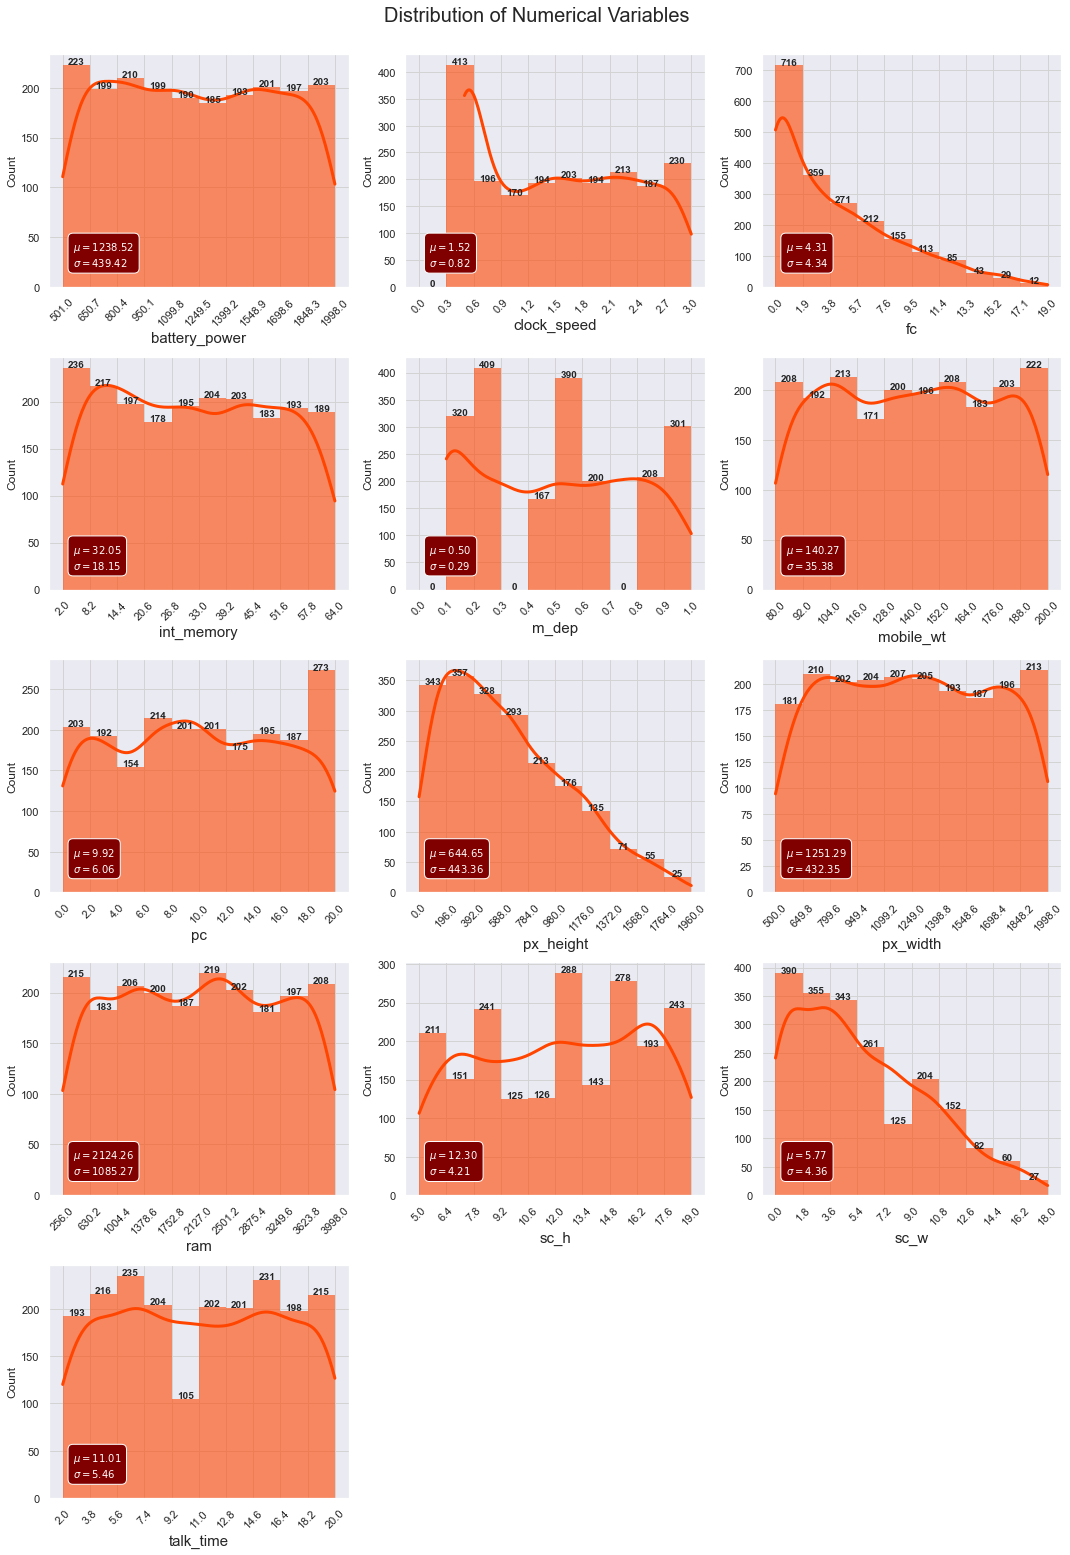

In [38]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15,22)) #, dpi=200
c = 'orangered'

for i, col in enumerate(df_numerical.columns):
    x = i//3
    y = i%3
    values, bin_edges = np.histogram(df_numerical[col], 
                                     range=(np.floor(df_numerical[col].min()), np.ceil(df_numerical[col].max())))                
    graph = sns.histplot(data=df_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x,y],
                         edgecolor='none', color=c, alpha=0.6, line_kws={'lw': 3})
    ax[x,y].set_xlabel(col, fontsize=15)
    ax[x,y].set_ylabel('Count', fontsize=12)
    ax[x,y].set_xticks(np.round(bin_edges,1))
    ax[x,y].set_xticklabels(ax[x,y].get_xticks(), rotation = 45)
    ax[x,y].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[x,y].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")
    textstr = '\n'.join((
    r'$\mu=%.2f$' %df_numerical[col].mean(),
    r'$\sigma=%.2f$' %df_numerical[col].std()
    ))
    ax[x,y].text(0.08, 0.2, textstr, transform=ax[x,y].transAxes, fontsize=10, verticalalignment='top',
                color='white', bbox=dict(boxstyle='round',facecolor='maroon', edgecolor='white', pad=0.5))
    
ax[4, 1].axis('off')
ax[4, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20) 
plt.tight_layout()   
plt.subplots_adjust(top=0.95)
plt.show()

* Conclusion

* By looking at the graphs above, we can easily understand the statistical values of each feature, including the minimum and maximum values, and the average and standard deviation.
* In some features, including __px_height (Pixel Resolution Height)__ and __sc_w (Screen Width of mobile in cm)__, many values close to zero are observed, which seem like __noise__!

Step 5 | Data Cleansing


    
__Data cleansing__ is the process of identifying and correcting errors in data. It is important in machine learning as the accuracy and reliability of the resulting model are heavily dependent on the quality of the input data.

Step 5.1 | Duplicate Values Detection 

In [39]:
df.duplicated().sum()

0

* Conclusion

* The dataset does not contain duplicate samples.

Step 5.2 | Missing Value Detection 

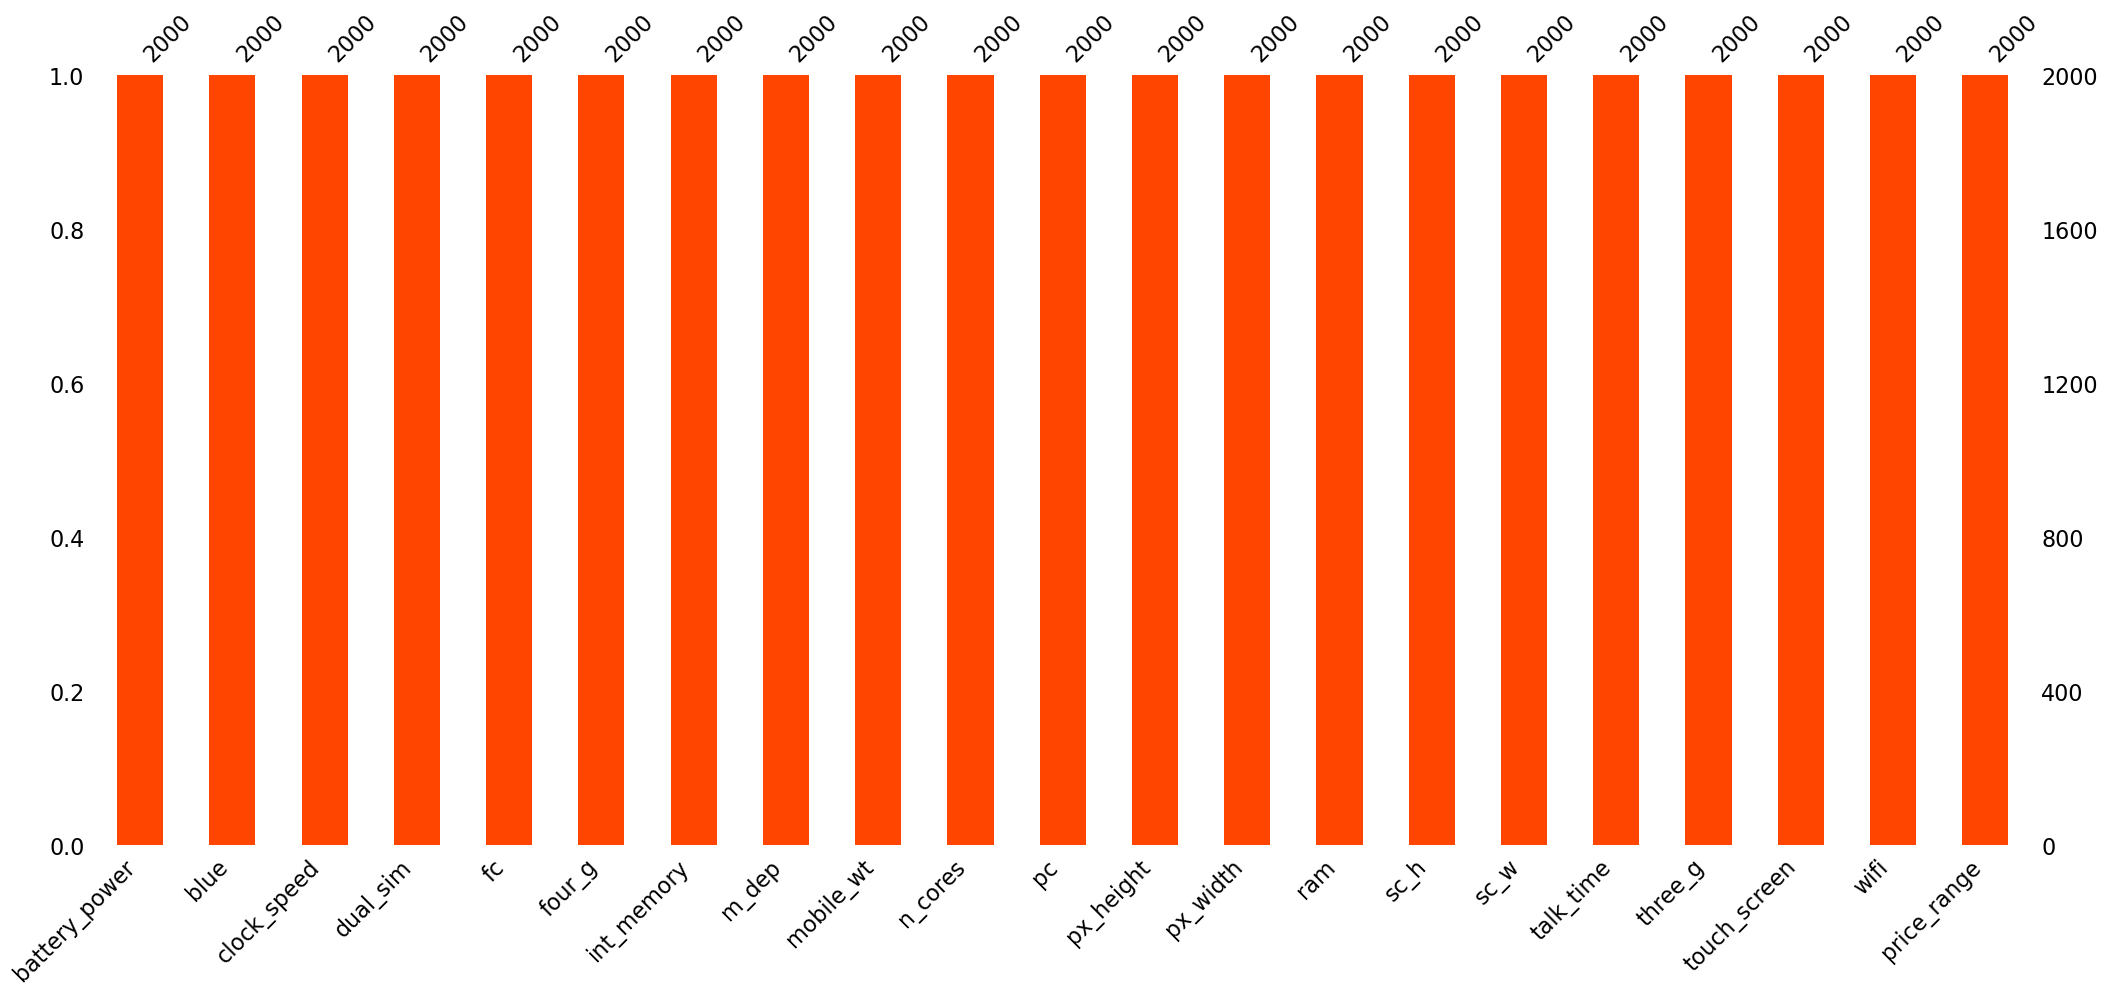

In [10]:
# Generate the missing values matrix using missingno.bar()
msno.bar(df, color='orangered')

# Display the plot
plt.show()

* Conclusion

* There is no missing value in the dataset

Step 5.3 | Noise Detection 

Let's take a look at `px_height` (Pixel Resolution Height) and `sc_w` (Screen Width of mobile in cm) feature distributions again:

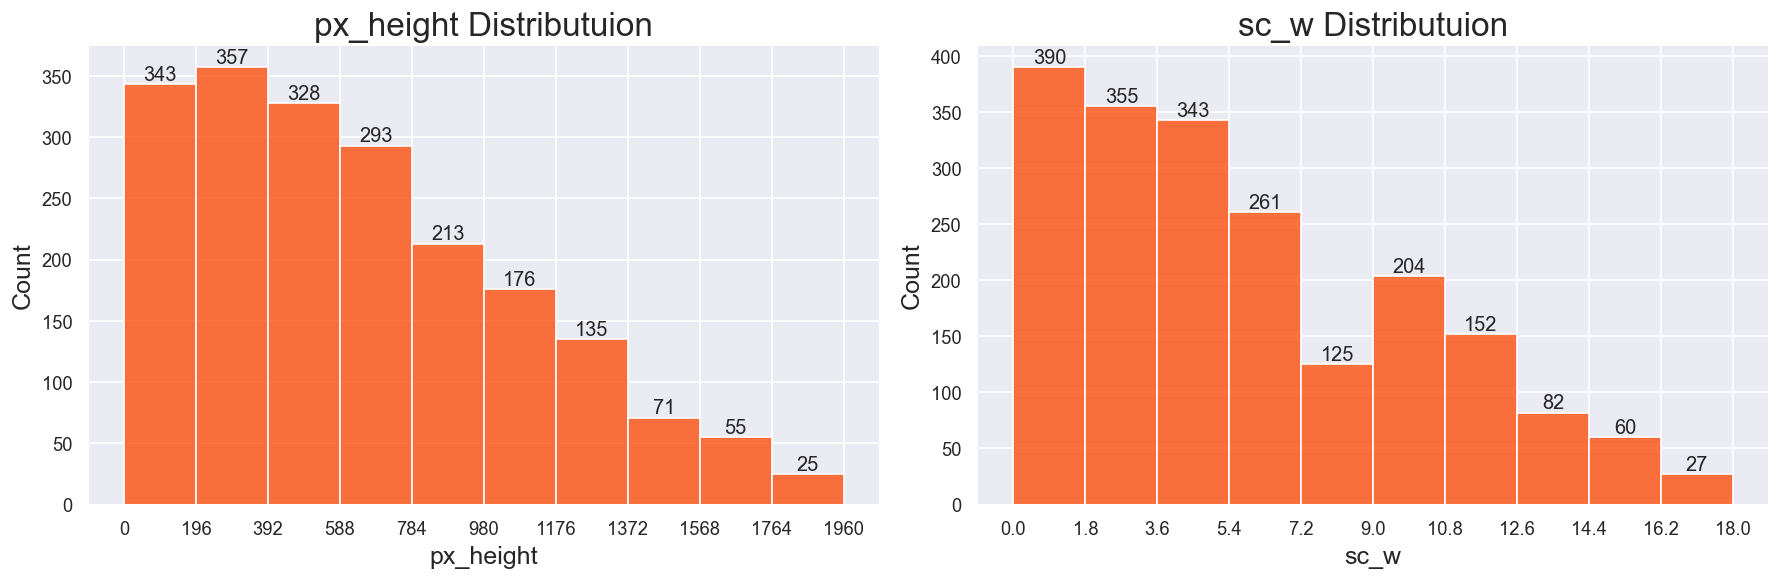

In [40]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)

# Plot px_height histogram:
_, bin_edges = np.histogram(df['px_height'], range=(np.floor(df['px_height'].min()), np.ceil(df['px_height'].max())))                                     
graph1 = sns.histplot(x='px_height', data=df, bins=bin_edges, color='orangered', ax=ax[0])
ax[0].set_xticks(np.round(bin_edges,1))
ax[0].set_title('px_height Distributuion', fontsize=20) 
for cont in graph1.containers:
        graph1.bar_label(cont)

# Plot sc_w histogram:
_, bin_edges = np.histogram(df['sc_w'], range=(np.floor(df['sc_w'].min()), np.ceil(df['sc_w'].max())))
graph2 = sns.histplot(x='sc_w', data=df, bins=bin_edges, color='orangered', ax=ax[1])
ax[1].set_xticks(np.round(bin_edges,1))
ax[1].set_title('sc_w Distributuion', fontsize=20)      
for cont in graph2.containers:
        graph2.bar_label(cont)
        
plt.tight_layout()
plt.show()

* Problem
    
As seen __px_height (Pixel Resolution Height)__ and __sc_w (Screen Width of mobile in cm)__ contain many values of zero and close to zero, which look like noise, but since we do not have enough knowledge in this domain, we cannot set a __definite__ lower limit as an acceptable value for these features. Anyway after researching on the internet, we found out that:

* Some of the earliest commercially available mobile phones, like the Motorola DynaTAC 8000X, had a screen resolution of only 5 pixels in height.

* Some of the earliest mobile phones with screens had a width of around 2-3 centimeters.
    
    
* Strategy

In the following, one of the models we intend to implement is __SVM__ and __one of the advantages of SVM__ is that __it is less sensitive to noise and outliers__ in the data compared to other algorithms, such as decision trees. Therefore, according to the above explanations, we consider the value of 5 for px_height and the value of 2 for sc_w as the minimum acceptable values and detect the index of noise samples, but do not take action to clean or impute them. We don't do it until we reach noise-sensitive models like decision tree!

In [41]:
# Detect Noise values in sc_w 
sc_w_NoiseIndex = df[df['sc_w'] < 2].index

# Detect Noise values in px_height
px_height_NoiseIndex = df[df['px_height'] < 5].index

In [42]:
print('The number of detected noise values for sc_w: ', len(sc_w_NoiseIndex))
print('The number of detected noise values for px_height: ', len(px_height_NoiseIndex))

The number of detected noise values for sc_w:  390
The number of detected noise values for px_height:  9


Step 5.4 | Feature Selection

* Definition
    
__Feature selection__ is the process of __selecting a subset of relevant features__ from a larger set of features in a dataset to improve the performance of a machine learning model. The selected features are used to build a model that can accurately predict the target variable, while __ignoring irrelevant or redundant features__ that can negatively impact model performance.    

    
* Advantages
    
1. It can __improve model accuracy by reducing overfitting__, which occurs when a model is too complex and captures noise in the data instead of the underlying patterns.

2. It can __reduce the time and computational resources__ required to train a model by removing unnecessary features, leading to faster model development and deployment.

3. It can __improve the interpretability of the model__ by identifying the most important features that are driving the predictions, making it easier for humans to understand the model and its decision-making process.

    


    
* Techniques
    
* __Filter methods:__ These methods use statistical measures to rank the features based on their correlation with the target variable, and select the top-ranked features. 
    * __Examples__ -  Pearson correlation coefficient, chi-squared test
    

* __Wrapper methods:__ These methods evaluate the performance of a machine learning model on different subsets of features, and select the subset that produces the best performance. 
    * __Examples__ - Drop-column feature selection.

    
* __Embedded methods:__ These methods incorporate feature selection as part of the model training process, and select the most important features based on their contribution to the model performance. 
    * __Examples__ - LASSO regression, Ridge regression, Decision trees

    
* __Dimensionality reduction:__ These methods reduce the number of features by transforming the original feature space into a lower-dimensional space, while retaining as much of the variance in the data as possible. 
    * __Example__ - PCA

* Strategy
    
* Among the filter methods, we will perform the __Pearson correlation coefficient__. 
* We will perform __Drop-column Feature Importance__ as a Wrapper method.
* We will implement models such as __Decision Tree__ and __Random Forest__ as Embedded methods.

* Step 5.4.1 | Pearson Correlation


__Pearson Correlation__ is a statistical measure that calculates the strength and direction of the linear relationship between two variables, with values ranging from `-1` (perfect negative correlation) to `1` (perfect positive correlation).

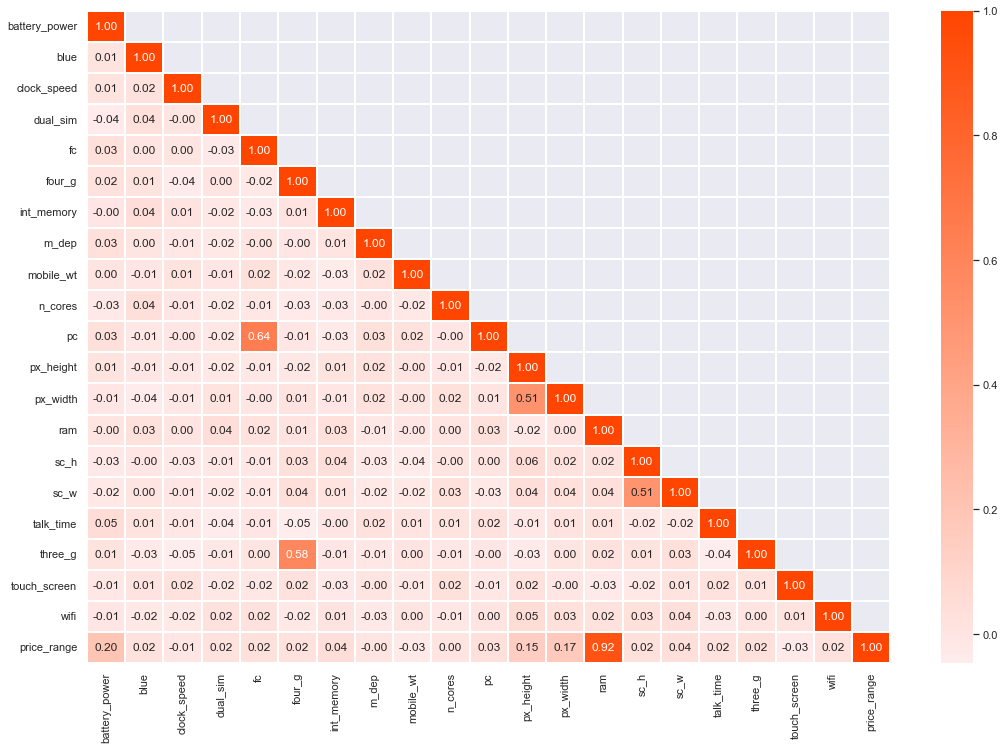

In [43]:
# Define a colormap
orangered_cmap = LinearSegmentedColormap.from_list('orangered', ['#FFECEC','orangered'])

# Calculation of the Spearman correlation
target = 'price_range'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr()

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(18,12))
sns.heatmap(corr, mask=mask, annot=True, cmap=orangered_cmap, fmt='.2f', linewidths=0.2)
plt.show()

* Conclusions

* `price_range` is highly correlated with `ram` (ρ = 0.92).
* `price_range` has a low correlation value with the rest of the features, but this cannot be used as a criterion to remove these features since the pearson correlation only expresses the linear relationship between two variables.
* Among the features, two features ‍‍‍‍‍‍`pc` and `fc` have the highest correlation with each other (ρ = 0.64).

* Step 5.4.2 | Drop-column Feature Importance

    
__Drop-column Feature Importance__ is a machine learning technique used to evaluate the importance of features in a dataset. It involves measuring the impact of removing a feature on the performance of a pre-trained model. The feature whose removal causes the largest decrease in the model's performance is considered the most important feature. Drop-column feature importance can be used in conjunction with algorithms that provide a built-in measure of feature importance. It is computationally efficient and can provide a more precise measure of feature importance.

* Note

* Drop-column Feature Importance method does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is __for a particular model__.

* Note

* In this project, the target contains 4 classes and the it is __completely balanced__. Also, none of the classes is of particular importance compared to the other. Therefore, in this project, __accuracy__ can be a good metric to measure the performance of the models.
    
    
* If we want to evaluate the performance of our models using precision, recall, and f1-score, since our dataset is multi-class and each class is equally important and needs to be evaluated separately, we use __macro-level metrics__.

Next, we will implement Drop-column Feature Importance Technique through a function using __cloning__:

In [44]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    """
    Estimate the feature importance of a given machine learning model using the Drop-column Feature Importance technique.

    Parameters
    ----------
    model : object
        A scikit-learn compatible estimator object.
    X_train : pandas.DataFrame
        The training dataset containing the feature variables.
    y_train : pandas.Series
        The training dataset containing the target variable.
    random_state : int, optional (default=0)
        The random seed used to initialize the model's random state.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with two columns, 'feature' and 'feature importance', where the latter represents the decrease in model 
        performance when a feature is removed. The DataFrame is sorted in descending order by 'feature importance'.
    """
    
    # list containing feature importances
    importances = []
    # Clone the model
    model_clone = clone(model)
    # Set random_state for comparability
    model_clone.random_state = random_state
    # Train the model
    model_clone.fit(X_train, y_train)
    # Create the cross-validation object using StratifiedKFold 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Score the benchmark model using cross-validation
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring='accuracy').mean()

    
    # Iterate over all features and store feature importance
    for col in X_train.columns:
        # Clone the model
        model_clone = clone(model)
        # Set random_state for comparability
        model_clone.random_state = random_state
        # Traint the model on the the dataset with a single feature removed
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Score the droped-column model
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring='accuracy').mean()
        # Store feature importance which is defined as the difference between the benchmark and the new model score
        importances.append(benchmark_score - drop_column_score)
        
    # Return the features along with their importances in the form of a dataframe
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)
           
    return importances_df                  

Define a function to __visualize__ the results of __Drop-column Feature Importance technique__ using bar charts:

In [45]:
def drop_column_importance_plot(model, X_train, y_train):
    """
    Visualize the feature importance of a given machine learning model using the Drop-column Feature Importance technique.

    Parameters
    ----------
    model : object
        A scikit-learn compatible estimator object.
    X_train : pandas.DataFrame
        The training dataset containing the feature variables.
    y_train : pandas.Series
        The training dataset containing the target variable.

    Returns
    -------
    None
        Displays a horizontal bar plot showing the feature importances based on the drop-column technique.
    """
    
    # Call drop-column feature importance function
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
    # Rename columns
    df_drop_column.columns = ['Feature', 'Feature Importance']
    
    # Plot barchart
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='orangered')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()

In the next steps, we will use these functions before building our final model regarding each classification algorithm to detect redundant features.

Step 6 | Bivariate Analysis


    
We have considered each feature individually in univariate analysis in __Step 4__. Now we will examine the features again with respect to the target variable. First, we will identify the relationship between the target variable and the __categorical features__. Then we will look at the __numerical features__ compared to the target variable.

* Step 6.1 | Categorical Features vs Target

    
We will create __100% stacked bar charts__ showing the proportion of `price_range` for each category of categorical features seprately:

In [46]:
# Define the target name in a variable for simplicity
Target = 'price_range'

# Define a list containing names of the categorical features in the dataset 
Cat_Features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'n_cores']

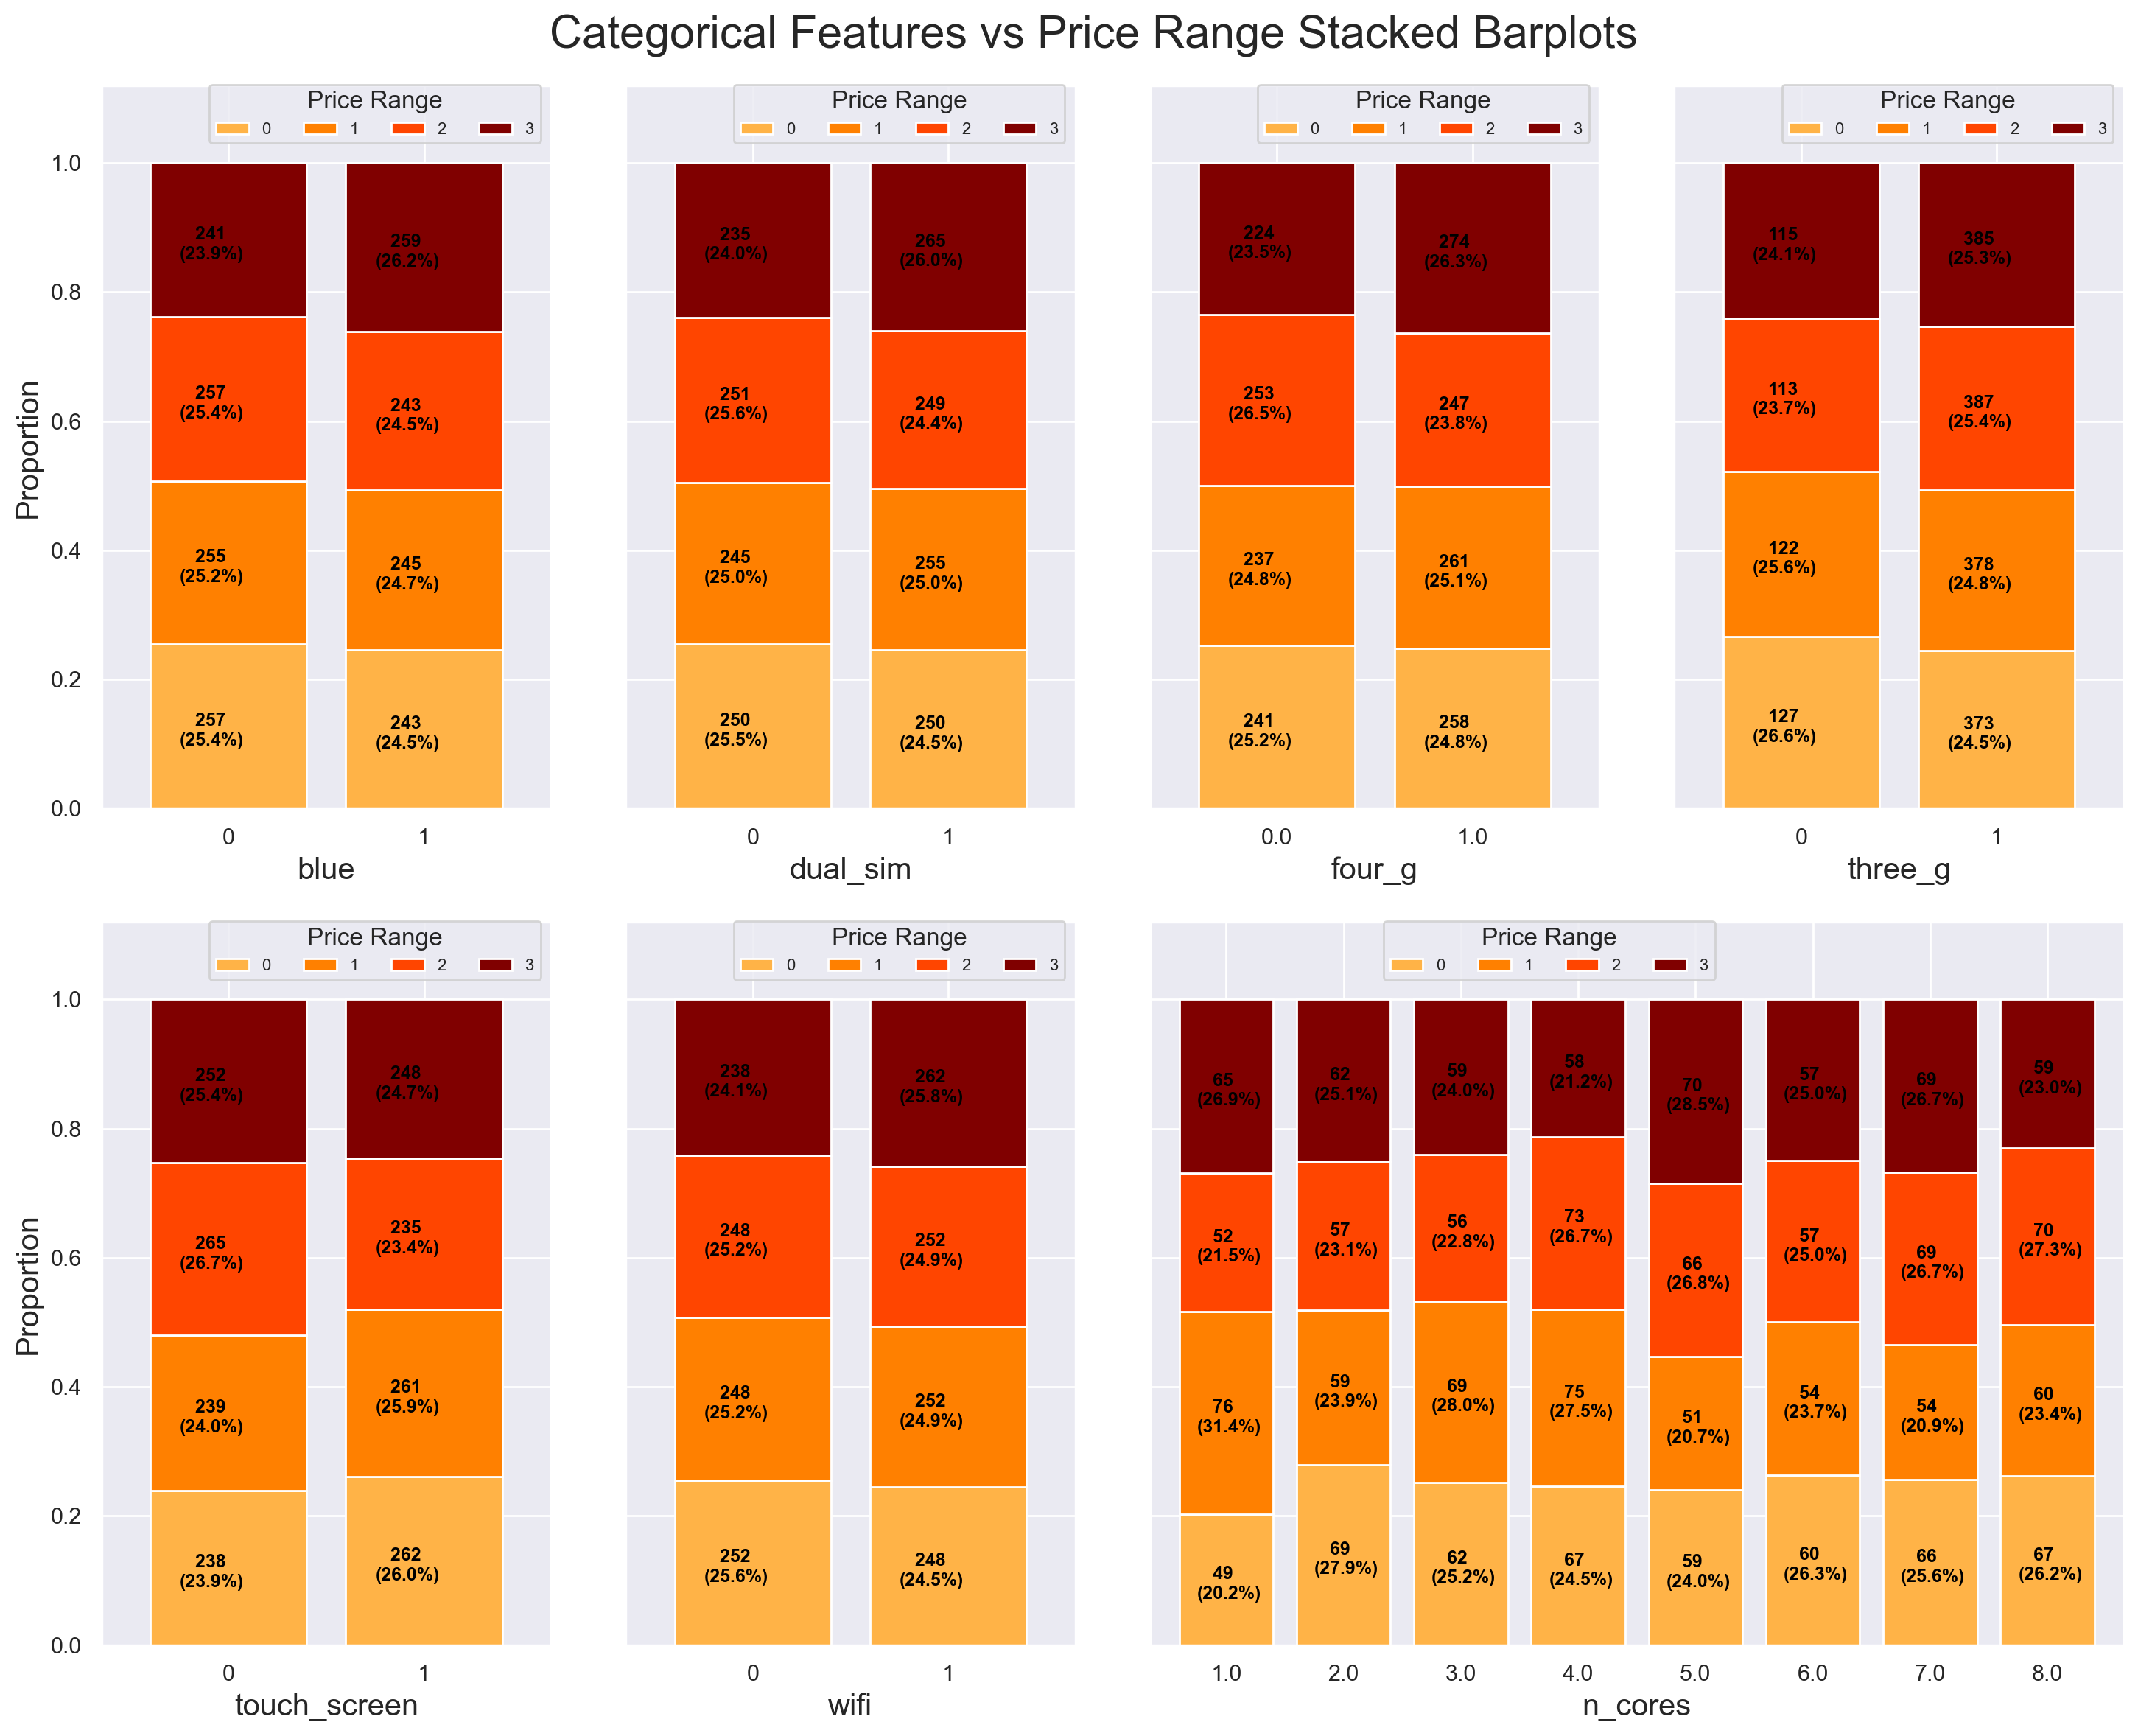

In [47]:
# Create a 2x4 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,12), dpi=200)

# Span subplot over two columns
ax[1,2] = plt.subplot2grid((2,4), (1,2), colspan=2)

for i,col in enumerate(Cat_Features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ffb347', '#ff8000', '#ff4500','#800000'])
    
    # Plot stacked bar charts
    x, y = i//4, i%4
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.25, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'   {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='Price Range', loc=(0.24,0.92), fontsize=8, ncol=4)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    # Increase xlabel & ylabel font sizes
    ax[x,y].set_ylabel('Proportion', fontsize=15)
    ax[x,y].set_xlabel(col, fontsize=15)        

plt.suptitle('Categorical Features vs Price Range Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

* Conclusions

* Among the categorical features seen in the above plot, ‍‍‍‍‍‍‍`three_g`, `n_cores`, and `touch_screen` have a greater impact on the target because by changing the category in these features, the percentage of samples belonging to each class of the target has changed more significantly.

* Step 6.2 | Numerical Features vs Target

    
We will try to find the mean and distribution of numerical features across different price_range classes:

In [48]:
# Define a list containing names of the numerical features in the dataset 
Num_Features = df_numerical.columns

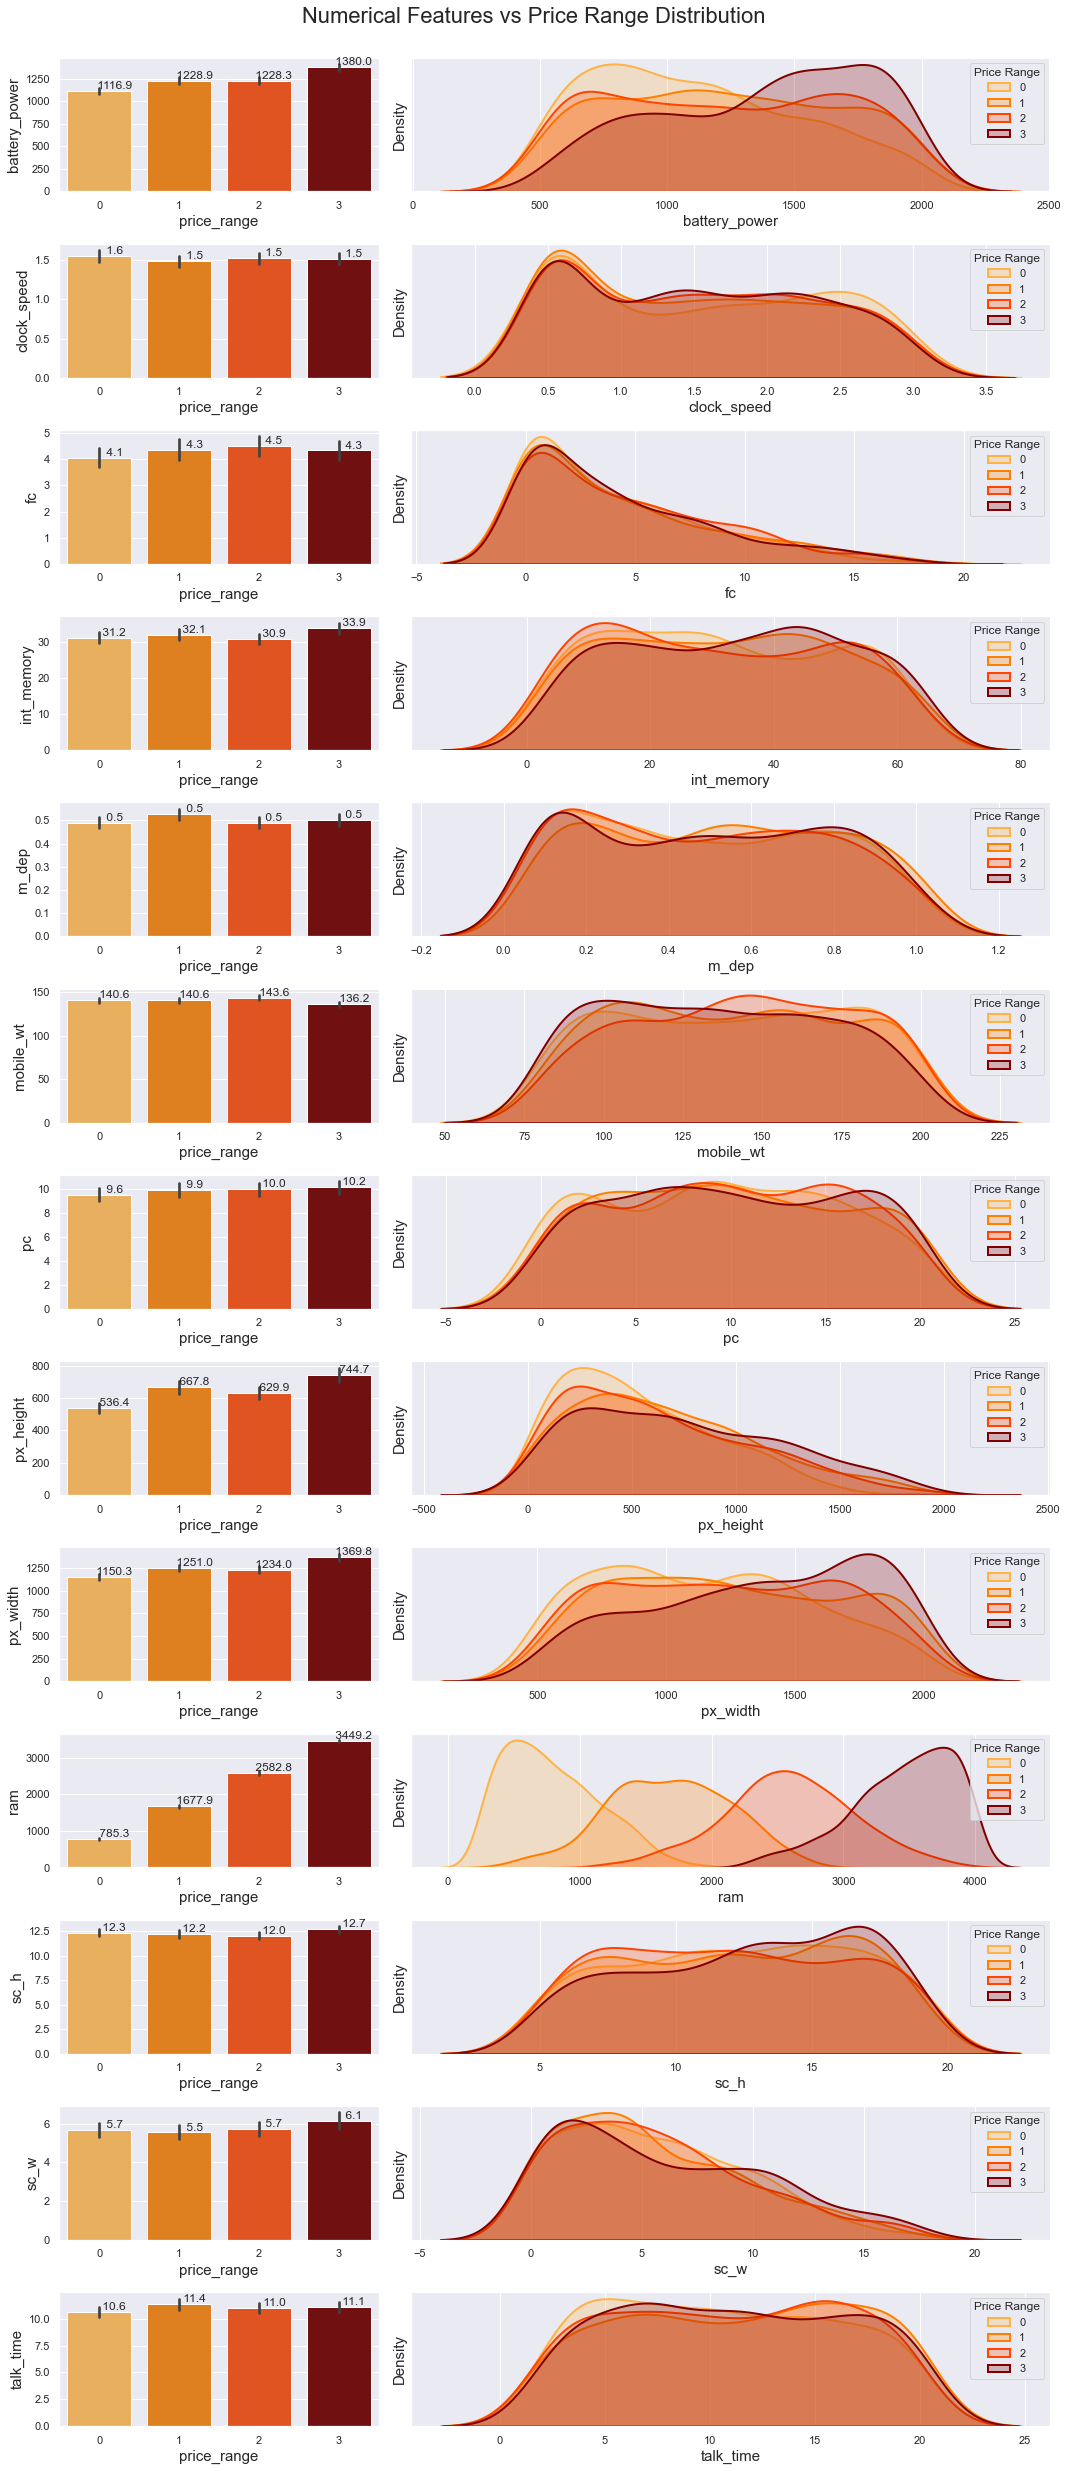

In [49]:
# Define Seaborn palette
sns.set_palette(['#ffb347', '#ff8000', '#ff4500','#800000'])

# Create a 13x2 grid of subplots
fig, ax = plt.subplots(13, 2, figsize=(15,35), gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    sns.kdeplot(data=df[df[Target]==2], x=col, fill=True, linewidth=2, ax=ax[i,1], label='2')
    sns.kdeplot(data=df[df[Target]==3], x=col, fill=True, linewidth=2, ax=ax[i,1], label='3')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Price Range', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.1f')
        
# Increase font size of x and y labels
for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i,j].set_xlabel(ax[i,j].get_xlabel(), fontsize=15)
        ax[i,j].set_ylabel(ax[i,j].get_ylabel(), fontsize=15)

plt.suptitle('Numerical Features vs Price Range Distribution', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

* Conclusions
    
* Among the numerical features seen in the above diagram, first the `ram` feature and then the `battery_power`, `px_height` and `px_width` have the greatest impact on the target because the distribution and average amount of data belonging to each class of the target in these features have changed significantly!

Step 7 | SVM Model Building

### * SVM

__Support Vector Machine (SVM)__ is a popular machine learning algorithm used for classification and regression tasks. It works by finding the optimal hyperplane that separates the data points into different classes. The hyperplane is determined by maximizing the margin, which is the distance between the hyperplane and the nearest data points of each class. 

    
#### * Advantages of SVM classifier:

* __Robust to noise & outliers__ - SVM is less sensitive to noise & outliers compared to other algorithms, making it suitable for tasks where the presence of noise & outliers is expected.
* __Good generalization__ - SVM is known for its ability to generalize well, meaning it can perform well on new and unseen data.
* __Handles non-linear data__ - SVM can handle non-linear decision boundaries, which makes it useful in situations where the data is not linearly separable.
* __Flexibility in kernel selection__ - SVM provides flexibility in selecting different kernel functions such as linear, polynomial, and radial basis function (RBF), allowing it to work with a wide range of datasets.
* __Effective in high-dimensional spaces__ - SVM can work well with high-dimensional datasets, which is useful in situations where the number of features exceeds the number of samples.


#### * Disadvantages of SVM classifier:

* __Computationally intensive__ - SVM is computationally intensive, meaning it can be slow and require a lot of memory when working with large datasets.
* __Sensitivity to hyperparameters__ - SVM is sensitive to the choice of parameters such as the kernel function and regularization parameters, which can affect its performance.
* __Limited interpretability__ - SVM does not provide explicit models for understanding the relationship between features and the target variable, making it difficult to interpret the results.
* __Bias-Variance Tradeoff__ - Like all machine learning algorithms, SVM is subject to the bias-variance tradeoff, meaning that it can be overfit or underfit the data, leading to poor performance.

* Step 7.1 | Scale Data using Standard Scaler

    
__SVM (Support Vector Machine)__ is a __distance-based__ classifier. SVM works by finding the boundary that best separates the data into classes, while maximizing the margin (the distance between the boundary and the closest data points from each class, known as support vectors). This means that SVM is based on the concept of __distance__ and seeks to find the optimal boundary that maximizes the distance between the classes. Therefore, Standard Scaling must be performed before model building:

Define the features (X) and the output labels (y) of the given dataset:

In [50]:
X = df.drop('price_range', axis=1)
y = df['price_range'] 

Perform train test split:

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [65]:
X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

Scale data using StandardScaler:

In [66]:
# Scale the training and test data using Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

* Note:

* It is very important that StandardScaler transformation should only be learnt from the training set, otherwise it will lead to __data leakage__.

SVM Hyperparameter Tuning

### * SVM Hyperparameter Tuning:
    
Hyperparameter tuning is important for SVM classifiers. SVM classifiers have several hyperparameters that need to be set before training the model, and the performance of the model can be highly sensitive to the values of these hyperparameters.

#### * SVM Classifier Hyperparameters:   

* __C -__ This hyperparameter controls the __regularization__ strength of the model. C represents the penalty parameter for misclassification. It determines the tradeoff between achieving a low training error and a low testing error. A larger value of C allows the model to fit the training data more closely, which may result in better performance on the training set but may lead to overfitting and poor performance on new data. On the other hand, a smaller value of C encourages the model to have a larger margin and to be more tolerant of misclassifications, which can result in better generalization to new data.
    
    
    
* __kernel -__ This hyperparameter defines the type of kernel function used to transform the input data into a higher dimensional space where a linear boundary can be found. Common kernel functions include the `linear`, `polynomial`, `rbf` (radial basis function), `sigmoid` and `precomputed` kernels.

    
* __gamma -__ Kernel coefficient for rbf, poly and sigmoid kernels.

    
* __degree -__ This hyperparameter is only relevant when using the polynomial kernel. It defines the degree of the polynomial function used to transform the input data.    
    
    
* __decision_function_shape -__ The decision_function_shape hyperparameter in SVM classifier specifies the strategy used to construct the multi-class decision function, and can take two values: `ovr` (one-vs-rest) and `ovo` (one-vs-one). The choice of strategy does not usually affect overall accuracy but can impact computational efficiency and interpretability. The `ovr` strategy is more computationally efficient but may lead to imbalanced class distributions, while the `ovo` strategy is more robust to noise and avoids imbalanced class distributions, but can be computationally expensive. The default value of 'ovr' is often used, and the choice of strategy is not a critical hyperparameter for most problems.

We will define a function that finds the optimal combination of hyperparameters to achieve the best __accuracy__ for our classifier. The function uses __GridSearchCV__ and __cross-validation__ (__StratifiedKFold__) to evaluate different combinations of hyperparameters, and selects the combination with the highest accuracy. The function returns the best classifier with the optimal hyperparameters and can be used to tune hyperparameters for future models as well:

In [67]:
def tune_hyperparameters(clf, param_grid, X_train, y_train):
    """
    Tunes the hyperparameters of a classifier using GridSearchCV and cross-validation.

    Parameters:
    ----------
    clf (estimator): A classifier object that implements the estimator interface.
    param_grid (dict): A dictionary of hyperparameter values to search over using GridSearchCV.
    X_train (array-like): The training input samples.
    y_train (array-like): The target values for the training input samples.

    Returns:
    --------
    estimator: The best classifier with the optimal hyperparameters.

    The function uses GridSearchCV to search over a specified hyperparameter grid and
    cross-validation using StratifiedKFold to evaluate the performance of different hyperparameter
    combinations. The function returns the best classifier model with the optimal hyperparameters.
    """
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

Define the hyperparameters grid for search:

In [68]:
# Define the hyperparameter grid to search
param_grid = [{'kernel': ['poly'], 
               'degree': [2, 3, 4, 5], 
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01, 0.1, 1, 10, 100, 1000]},
                  
              {'kernel': ['rbf','sigmoid'],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01, 0.1, 1, 10, 100, 1000]},
                  
              {'kernel': ['linear'],
               'C': [0.01, 0.1, 1, 10, 100, 1000]}
             ]


Tuning hyperparameters for Support Vector Machines (SVM) can be time-consuming as it involves training the model multiple times with different hyperparameter values and evaluating their performance to find the optimal set of hyperparameters. After tuning SVM hyperparameters once, we found that the __linear kernel__ is the optimal kernel for this dataset. Therefore, we limit our param_grid to the linear kernel to reduce the program's run time:

In [69]:
param_grid = {'kernel': ['linear'],
               'C': [ 0.1, 1, 10, 50, 100]
             }

Let's call __tune_hyperparameters__ function to find the optimal values for the SVM hyperparameters that best fit our data:

In [70]:
# Create a SVC object
svm = SVC(probability=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
svm_optimized = tune_hyperparameters(svm, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 50, 'kernel': 'linear'}


* Step 7.3 | SVM Model Evaluation

    
To evaluate the performance of our classifier, we define a function so that it can be used to evaluate subsequent models as well.

First, we define a function that provides a summary of the model's performance on the test data using the desired metrics:

In [71]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

Now we define a function that provides a complete report of the model's performance on the training and test data, plus the confusin_matrix of the model on the test data and the summary of the model performance using the above function:

In [86]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    # Set font scale
    sns.set(font_scale=1.5)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')
    
    # Create figure and subplots 
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))
    
    
    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax1.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 4.2)
    table.set_fontsize(12)
    ax1.axis('tight')
    # Hide the axes
    ax1.axis('off')
    # set the title
    ax1.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('orangered')

    
    cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
    # Plot confusion matrix for test set
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot(ax=ax2)
    ax2.set_title('Confusion Matrix for Test Data')                                     
    ax2.grid(False)
            
    plt.tight_layout()
    plt.show() 

Let's call the above function to evaluate our SVM classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.98      0.97      0.98       400
           2       0.98      0.98      0.98       400
           3       0.99      0.99      0.99       400

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       0.99      0.97      0.98       100
           2       0.97      0.98      0.98       100
           3       0.99      0.98      0.98       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98 

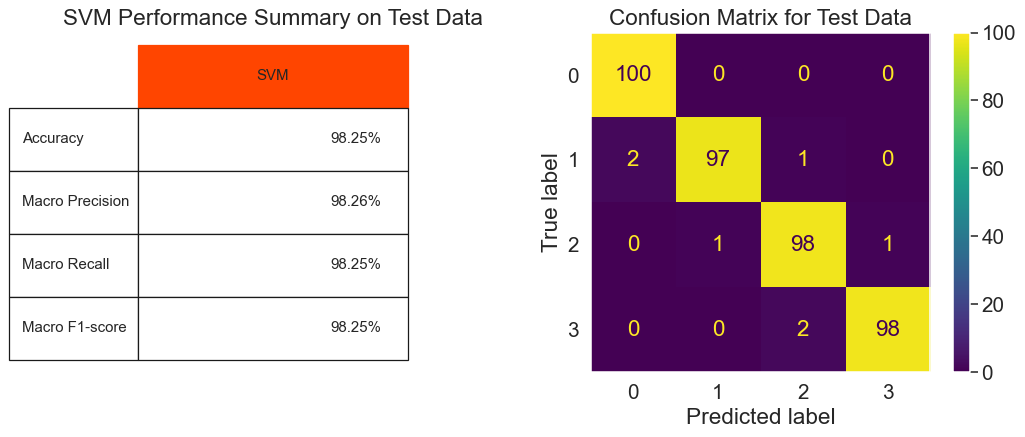

In [87]:
model_evaluation(svm_optimized, X_train, X_test, y_train, y_test, 'SVM')

    
For the __SVM classifier__, we got the remarkable __98.25%__ accuracy even though our __dataset was noisy__! If we examine the confusion matrix of the model, out of 400 mobile phones, the model made errors just in 7 cases to predict their price range.

In [88]:
# Save the final performance of SVM classifier
svm_result = metrics_calculator(svm_optimized, X_test, y_test, 'SVM')

Step 8 | Decision Tree Model Building

### * Decision Tree:

__Decision Tree__ is a supervised machine learning algorithm that uses a tree-like model of decisions and their possible consequences. It works by recursively splitting the data into subsets based on the values of the features, with the goal of minimizing a criterion, such as `Gini` impurity or `entropy`.
    
#### Advantages of Decision Tree:

* __Easy to interpret and explain__ - Decision Trees are easy to interpret and explain, even for complex models.
* __Handles both numerical and categorical data__ - Decision trees can handle both numerical and categorical data.
* __Nonlinear relationships between parameters do not affect tree performance__ - Decision trees can handle nonlinear relationships between parameters without affecting performance.

#### Disadvantages of Decision Tree:

* __Prone to overfitting__ - Decision trees are prone to overfitting, __especially when trained with noisy or incomplete data sets.__
* __Unstable__ - Small variations in the data can result in a completely different decision tree being generated
* __Poor approximation of complex functions__ - Decision Trees may not be suitable for approximating complex functions, as they are limited by the axis-parallel splits at each node.

Note:

* Decision Trees do not require standard scaling of the data before model building. Standard scaling is typically used for algorithms that are sensitive to the scale of the input features, such as distance-based algorithms like KNN and SVM.

Step 8.1 | Noise Treatment using KNN Imputer

__Decision Tree__ is a __noise-sensitive__ algorithm and __prone to overfitting__, especially when trained with noisy data. Therefore, we need to clear the data set. Since the number of noise values detected in the dataset in __step 5.3__ is high, we cannot remove the corresponding rows from the dataset. On the other hand, `px_height` and `sc_w` containing noise values, are considered important features in target estimation and we cannot remove any of them from the dataset. Therefore, we use __KNNImputer__ to impute these noise values:

KNN Imputer:
    
* __KNN Imputer__ is a machine learning technique used to __impute or fill in missing values and noise values__ in a dataset. The technique works by finding the __k-nearest neighbors__ of a data point with missing values and then imputing the missing values with the __average__ of those neighbors.

In [89]:
# Make a copy of dataset
df_denoised = df.copy()

# Replace the noise values with NaN
df_denoised.loc[sc_w_NoiseIndex,'sc_w'] = np.nan
df_denoised.loc[px_height_NoiseIndex,'px_height'] = np.nan

# Create a KNN imputer object with k=2
imputer = KNNImputer(n_neighbors=2)

# Impute the noise values
imputed_data = imputer.fit_transform(df_denoised)

# Convert array to dataframe
df_denoised = pd.DataFrame(imputed_data, columns=df_denoised.columns)

# Define the features (X) and the output labels (y)
X_denoised = df_denoised.drop('price_range', axis=1)
df_denoised['price_range'] = df_denoised['price_range'].astype(int)
y = df_denoised['price_range'] 

Step 8.2 | Decision Tree Hyperparameter Tuning

Decision Tree Hyperparameter Tuning:

Hyperparameter tuning is crucial for decision trees because they are prone to overfitting. Overfitting occurs when the tree is too complex and fits the training data too closely, __capturing even the noise in the data__. Tuning the hyperparameters can help to avoid overfitting and improve the performance of the model on new, unseen data.

Ways to Prevent Overfitting in Decision Trees:
    
* __Pruning__ - Removing branches of the tree that do not contribute much to the classification.
* __Using ensemble methods__ - Combining multiple decision trees to obtain a more robust model.
* __Tune Hyperparameters__ - Hyperparameter tuning can help prevent decision tree classifiers from overfitting by controlling the complexity of the tree.
    

Most Common Hyperparameters in Decision Trees: 

* __Criterion:__ This hyperparameter determines the criterion used to measure the quality of a split. Commonly used criteria are `Gini Impurity` and `Information Gain`.

* __Maximum depth:__ This hyperparameter controls the maximum depth of the tree. The deeper the tree, the more complex it becomes, which can lead to overfitting. Setting a maximum depth can prevent overfitting by limiting the size of the tree.

* __Minimum samples per split:__ This hyperparameter sets the minimum number of samples required to split an internal node. If the number of samples at a node is less than this value, the node cannot be split further. This can also prevent overfitting by limiting the size of the tree.

* __Minimum samples per leaf:__ This hyperparameter sets the minimum number of samples required for a leaf node. If a leaf node has fewer samples than this value, it can be removed.

* __Maximum features:__ This hyperparameter determines the maximum number of features to consider when splitting a node. It is used to prevent overfitting by reducing the complexity of the model.

Again, we define our hyperparameters grid using the above hyperparameteres and then call __tune_hyperparameters__ function to find the best combination:

In [90]:
# Define the hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 15),
              'min_samples_split': np.arange(2, 10),
              'min_samples_leaf': np.arange(1, 10),
              'max_features': [None, 'sqrt', 'log2']} 

Let's call tune_hyperparameters function for hyperparameter tuning:

In [91]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X_denoised, y, test_size=0.2, random_state=0, stratify=y)

# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_optimized = tune_hyperparameters(dt, param_grid, X_train, y_train)

Best hyperparameters:
 {'criterion': 'gini', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 7}


Step 8.3 | Decision Tree Feature Subset Selection

    
In step 6, by examining the features with respect to the target variable, we realized that there are a number of features that do not have a large effect in the target estimation. By removing irrelevant features from the dataset using feature selection techniques, we can simplify our decision tree and reduce its complexity, which can lead to improve the accuracy of the model by reducing model overfitting. Therefore, in the following, we will use the __drop_column_importance_plot__ function __defined in Step 5.4.2__ in order to implement the __Drop-column Feature Importance__ technique to detect redundant features:

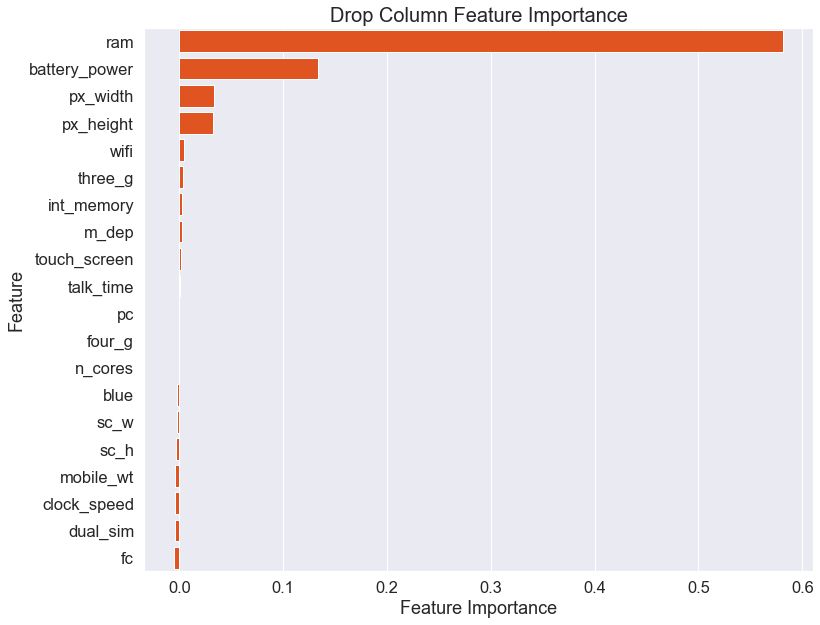

In [92]:
drop_column_importance_plot(dt_optimized, X_train, y_train)


In the Drop-Column feature importance output results, several features with negative importance are observed. Removing these features improves the performance of the model. Let's filter our the dataset:

In [93]:
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(dt_optimized, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

We can see the __remaining features__ in the dataset (relavant features):

In [94]:
pd.DataFrame(selected_features)

,feature
0,ram
1,battery_power
2,px_width
3,px_height


Let's tune the hyperparameters of our model again after removing the irrelevant features:

In [95]:
# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_optimized = tune_hyperparameters(dt, param_grid, X_train, y_train)

Best hyperparameters:
 {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 7}


Step 8.4 | Decision Tree Model Evaluation

Let's evaluate our Decision Tree performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.96      0.95      0.96       400
           2       0.92      0.97      0.95       400
           3       0.99      0.94      0.96       400

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       100
           1       0.83      0.86      0.85       100
           2       0.80      0.83      0.81       100
           3       0.91      0.84      0.87       100

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.87 

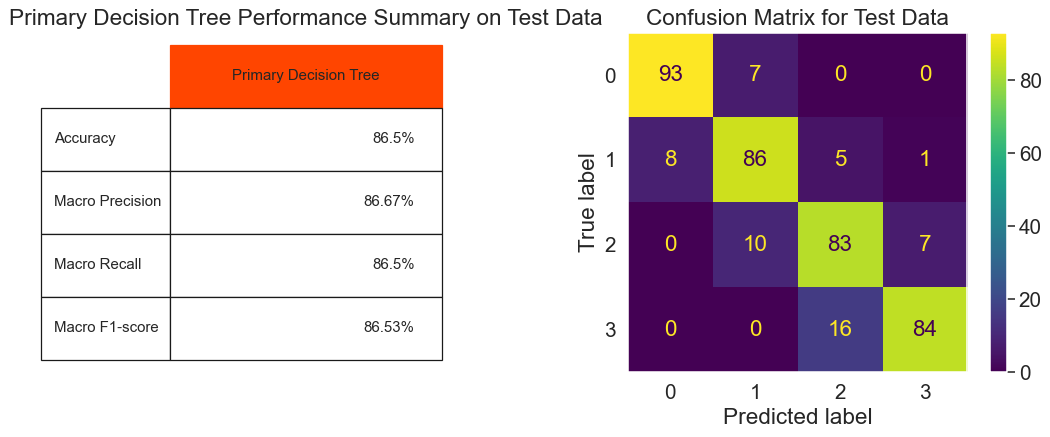

In [96]:
model_evaluation(dt_optimized, X_train, X_test, y_train, y_test, 'Primary Decision Tree')


If we compare the accuracy obtained on both training and test sets, we see __a decrease of 7% on the accuracy of test set compared to training set__, which shows that __the model is fairly overfit.__ Overfitting of the model is due to its high variance, and in the following, we try to prevent the model from overfitting by applying a small change in the value of hyperparameters, hoping that the performance of the model will improve on the test data.

How each Decision Tree Classifier Hyperparameter Can Reduce Model Variance?


* __Maximum depth (max_depth)__ - This hyperparameter controls the maximum depth of the decision tree. By limiting the depth of the tree, we can prevent the model from becoming too complex and overfitting the training data, which can help reduce model variance.
* __Minimum samples for a split (min_samples_split)__ - This hyperparameter specifies the minimum number of samples required to split an internal node. By increasing this value, we can prevent the model from splitting on small, noisy subsets of the data, which can help reduce model variance.
* __Minimum samples for a leaf (min_samples_leaf)__ - This hyperparameter specifies the minimum number of samples required to be at a leaf node. By increasing this value, we can prevent the model from creating small, isolated leaves that capture noise in the training data, which can help reduce model variance.

Among the optimal values obtained for hyperparameters, we only decrease the value of `max_depth` from 9 to 8 in order to partially reduce the variance of the model:

In [97]:
# Build decision tree classifier considering the obtained optimal values for hyperparameters
dt_final = DecisionTreeClassifier(criterion='gini', 
                                  max_depth=8, 
                                  max_features=None, 
                                  min_samples_leaf=3, 
                                  min_samples_split=7,
                                  random_state=0)

# Train the final decision tree classifier
dt_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=7,
                       random_state=0)

Let's evaluate our final Decision Tree classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       400
           1       0.95      0.94      0.95       400
           2       0.93      0.95      0.94       400
           3       0.98      0.95      0.97       400

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       100
           1       0.84      0.87      0.86       100
           2       0.81      0.84      0.82       100
           3       0.92      0.84      0.88       100

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87 

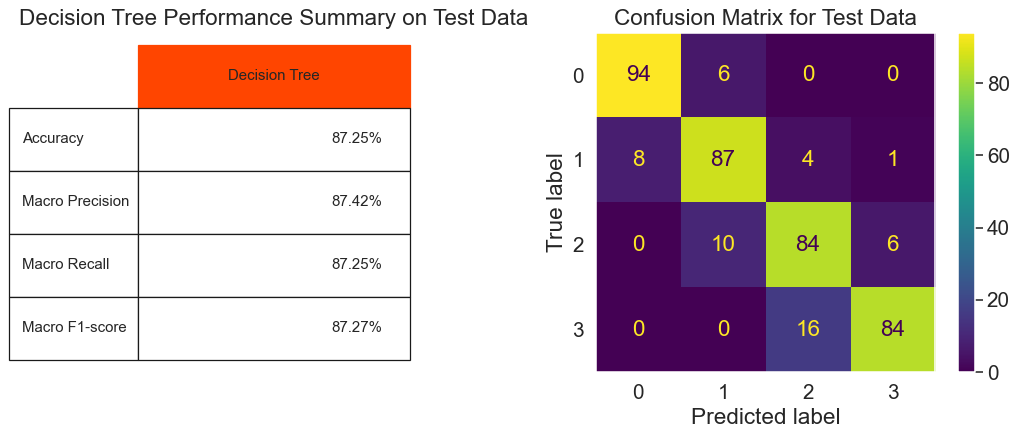

In [98]:
model_evaluation(dt_final, X_train, X_test, y_train, y_test, 'Decision Tree')


As can be seen, by using __only 4 features__ from the dataset in modeling (`ram`, `battery_power`, `px_width` and `px_height`), we achieved almost __89% accuracy on test data__ but our decision tree classifier is still somewhat overfit. Also, the performance of decision tree model is weaker than SVM, which can be __due to the noisy nature of the dataset and the tendency of the decision tree model to overfit on noisy data!__ Decision trees can be more robust to noise, especially when using ensemble methods like random forests. So, let's go on.

In [99]:
# Save the final performance of Decision Tree classifier
dt_result = metrics_calculator(dt_final, X_test, y_test, 'Decision Tree')

Step 9 | Random Forest Model Building

Random Forest:


__Random Forest__ is an ensemble learning classifier that combines multiple decision trees to improve prediction accuracy. It randomly selects a subset of features and data points for each tree, and then combines their predictions through a voting mechanism. 

Advantages of Random Forest:

* It is less prone to overfitting compared to decision trees, especially when there are highly correlated features in the data.
* It has high accuracy and can handle high-dimensional data with a large number of features.
* It can provide estimates of feature importance, which can be useful for feature selection and understanding the data.

Disadvantages of Random Forest:

* It can be computationally expensive and may require more resources than other algorithms.
* The interpretability of the model is reduced because it is composed of multiple decision trees.
* It may not perform well on small datasets or datasets with imbalanced classes.

Step 9.1 | Random Forest Hyperparameter Tuning

Random Forest Hyperparameter Tuning:
    
Optimizing the hyperparameters of a Random Forest can improve the accuracy of the model and prevent overfitting or underfitting on the data. A Random Forest model consists of multiple decision trees, which can be either shallow or deep. Shallow trees have a limited number of branches or levels, while deep trees have many branches or levels and are not fully grown. Deep trees tend to have low bias but high variance, which makes them suitable for bagging methods that aim to reduce variance. When selecting hyperparameters for Random Forest, it is important to consider __to have deep trees__ in choosing the range of values for __random forest__ hyperparameters.

Ways to Prevent Overfitting in Decision Trees:
    
* __Pruning__ - Removing branches of the tree that do not contribute much to the classification.
* __Using ensemble methods__ - Combining multiple decision trees to obtain a more robust model.
* __Tune Hyperparameters__ - Hyperparameter tuning can help prevent decision tree classifiers from overfitting by controlling the complexity of the tree.
    
     
Most Common Hyperparameters in Random Forest:    

* __n_estimators:__ The number of trees in the forest.
* __criterion:__ The function to measure the quality of a split. Common criteria include Gini impurity and information gain.
* __max_depth:__ The maximum depth of a tree. This can be used to control the complexity of the model and prevent overfitting.
* __min_samples_split:__ The minimum number of samples required to split an internal node.
* __min_samples_leaf:__ The minimum number of samples required to be at a leaf node.
* __bootstrap:__ Whether or not to sample with replacement when building the trees in the forest.
* __max_features:__ The maximum number of features to consider when splitting a node. This can be set as a number or a float (percentage) or 'sqrt' or 'log2'.

Again we set the range of values for each hyperparameter that we want to consider for our Random Forest classifier, and then use __tune_hyperparameters__ function to find the best combination of hyperparameters that provides the best results:

In [100]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [70, 100, 120, 150], 
    'max_depth': np.arange(10, 18),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

Let's call tune_hyperparameters function for hyperparameter tuning:

In [101]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X_denoised, y, test_size=0.2, random_state=0, stratify=y)

# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_optimised = tune_hyperparameters(rf, param_grid, X_train, y_train)

Best hyperparameters:
 {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


Step 9.2 | Random Forest Feature Subset Selection

    
Again by removing irrelevant features from the dataset using Drop-column Feature Importance, we can simplify our random forest, which can lead to improve the accuracy of the model by reducing model overfitting:

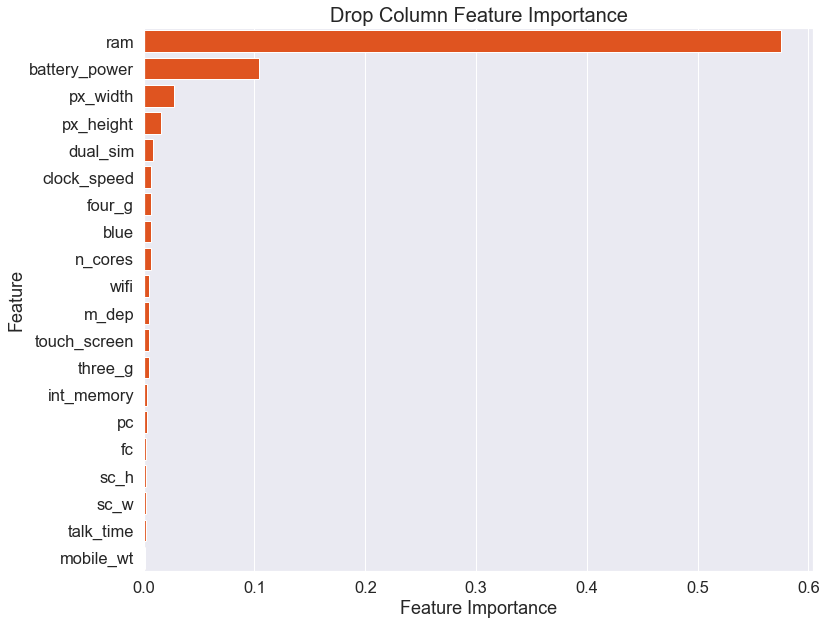

In [102]:
drop_column_importance_plot(rf_optimised, X_train, y_train)

    
The results of the feature importance analysis show that some of the features in the dataset contribute negatively towards making accurate predictions for the target variable. Therefore, we remove these features from our dataset:

In [103]:
feature_importances = drop_column_importance(rf_optimised, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

We can see the __remaining features__ in the dataset (relavant features):

In [104]:
pd.DataFrame(selected_features)

,feature
0,ram
1,battery_power
2,px_width
3,px_height


Let's tune the hyperparameters of our model again after removing the irrelevant features:

In [105]:
# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_optimised = tune_hyperparameters(rf, param_grid, X_train, y_train)

Best hyperparameters:
 {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Step 9.3 |  Random Forest Model Evaluation

Let's evaluate our Random Forest performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       100
           1       0.91      0.90      0.90       100
           2       0.84      0.87      0.86       100
           3       0.92      0.89      0.90       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91 

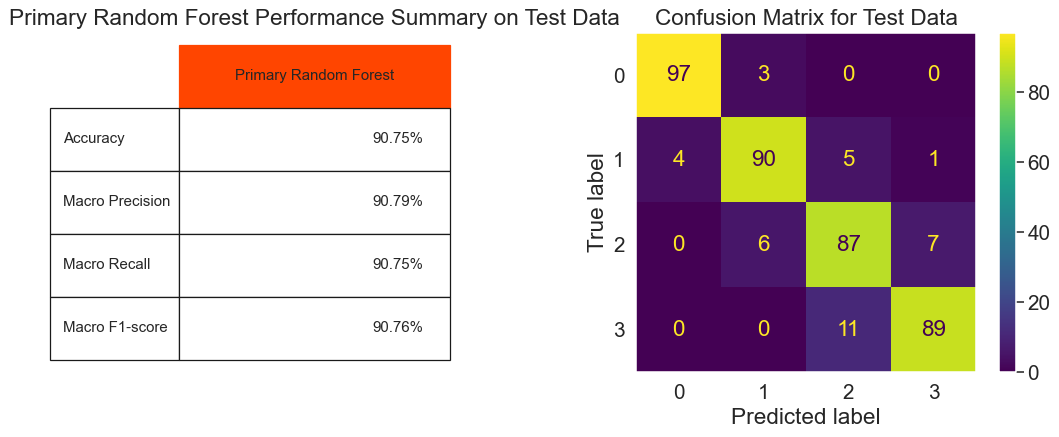

In [106]:
model_evaluation(rf_optimised, X_train, X_test, y_train, y_test, 'Primary Random Forest')

    
The model shows a 9% decrease in accuracy on the test set compared to the training set, indicating overfitting. Overfitting is caused by high variance, and adjusting hyperparameters is attempted to improve the model's performance on test data. Among the optimal values obtained for hyperparameters, we decrease the value of `max_depth` from 100 to 90 and increase the value of `min_samples_leaf` from 1 to 4 in order to partially avoid overfitting:

In [107]:
# Build decision tree classifier considering the obtained optimal values for hyperparameters
rf_final = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0,
                                  max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=90)

# Train the final decision tree classifier
rf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, max_features=None, min_samples_leaf=4,
                       n_estimators=90, random_state=0)

Let's evaluate our final Random Forest classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.96      0.97      0.97       400
           2       0.97      0.97      0.97       400
           3       0.99      0.98      0.98       400

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       100
           1       0.91      0.92      0.92       100
           2       0.85      0.87      0.86       100
           3       0.91      0.89      0.90       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91 

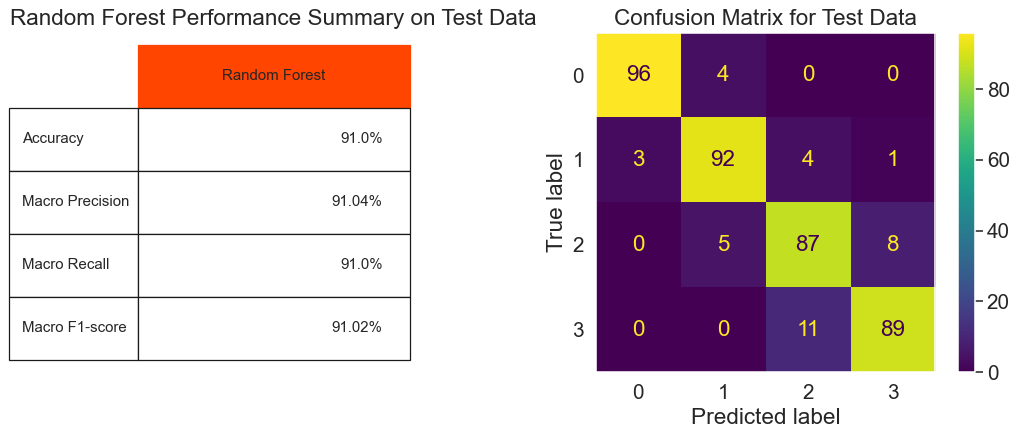

In [108]:
model_evaluation(rf_final, X_train, X_test, y_train, y_test, 'Random Forest')

    
As we expected, decision trees can be more robust to outliers and noise when we use ensemble methods such as __Random Forests__. Therefore, we see an almost __3% increase in the accuracy__ of the Random Forest model compared to the Decision Tree, but still, SVM has performed better due to being more resistant to noise. Again, in Random Forest modeling, we have used only the __4 more relevant features__ (`ram`, `battery_power`, `px_width` and `px_height`).

In [109]:
# Save the final performance of Random Forest classifier
rf_result = metrics_calculator(rf_final, X_test, y_test, 'Random Forest')

Step 10 | Conclusion & Sample Data Prediction

    
In this project, we faced a __multi-class classification__ problem and __the main challenge__ of which was __the noisy dataset and not having enough domain knowledge for dataset cleansing.__ As expected, the __SVM algorithm__ had a better performance than decision tree algorithms and ensemble learning algorithms based on it, such as Random Forest, due to __its lower sensitivity to noisy data__, and finally we got astonishing __98% accuracy on unseen data__.

Also, since __the dataset is completely balanced__ with respect to the distribution of the target classes and none of the classes have a special advantage over the other, the __accuracy metric__ is a proper metric to evaluate the performance of the models. In any case, we will check the performance of all three models on this dataset with the help of all metrics:

In [110]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([svm_result, dt_result, rf_result], axis=1).T

# Sort the dataframe in descending order based on accuracy
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# Color the accuracy column
results.style.applymap(lambda x: 'background-color: orangered', subset='Accuracy')

,Accuracy,Macro Precision,Macro Recall,Macro F1-score
SVM,98.25%,98.26%,98.25%,98.25%
Random Forest,91.0%,91.04%,91.0%,91.02%
Decision Tree,87.25%,87.42%,87.25%,87.27%


In the following, we can check the performance of the classifiers based on accuracy in the form of a bar chart:

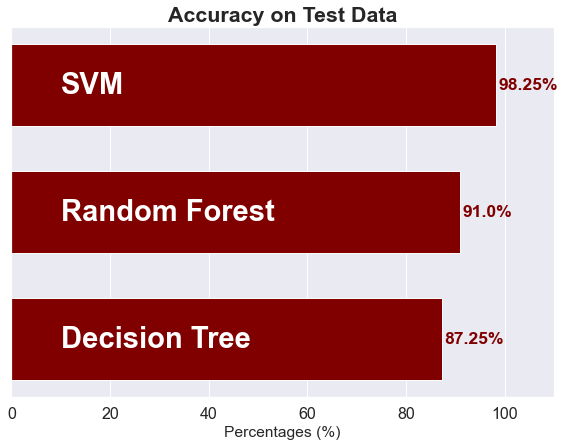

In [111]:
# Prepare values
results.sort_values(by='Accuracy', ascending=True, inplace=True)
accuracies = results['Accuracy'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 7), dpi=70)
ax.barh(results.index, accuracies, color='maroon', height=0.65)

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(accuracies, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='maroon', fontsize=18)
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=30)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("Accuracy on Test Data", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()


    
Among the examined classifiers, __SVM__ got the best accuracy due to its resistance to noise:
    
🏆 Accuracy = 98.25%

Finally, we predict the class for test.csv samples using the SVM model:

In [113]:
from sklearn.impute import SimpleImputer

In [115]:
# Define the features (X) and the output labels (y) of the given dataset:
X = df.drop('price_range', axis=1)
y = df['price_range'] 

# Create a pipeline to scale the data and train an SVM classifier using obtained optimal hyperparameters
svm_pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Fill missing values with zero
                        ('scaler', StandardScaler()), 
                        ('svm', SVC(probability=True, C=50, kernel='linear', random_state=0)) 
                        ])

# Train the SVM classifier on the whole dataset
svm_pipeline.fit(X, y)

# Read samples
df_samples = pd.read_csv('test.csv')

# Remove id column
df_samples.drop('id', axis=1, inplace=True)

# Predict samples class
df_samples['price_range_pred'] = svm_pipeline.predict(df_samples)
df_samples['price_range_pred']

0      3
1      3
2      2
3      3
4      1
      ..
995    2
996    1
997    0
998    2
999    2
Name: price_range_pred, Length: 1000, dtype: int64

In [116]:
import joblib

# Save the model to a file
joblib.dump(svm, 'svm_device_price_classifier.pkl')

['svm_device_price_classifier.pkl']

In [ ]:
# Load the saved model from the file
model_svm = joblib.load('svm_device_price_classifier.pkl')

<h2 align="left"><font color='maroon'>Best Regards!</font></h2>